In [ ]:
# 단기 예측
# These codes are from the link below
# https://www.youtube.com/watch?v=QIUxPv5PJOY

import math
import pandas_datareader as web
import pandas as pd
import numpy as np
# numpy : Numerical Python, 고성능의 수치계산을 위해 제작되었음, C언어로 구현된 파이썬 라이브러리
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# To calculate Linear Algebra faster when you use Machine learning, use AVX
# It will improve the speed of learning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.style.use('fivethirtyeight')

In [ ]:
pip install --upgrade pandas

     |████████████████████████████████| 11.3 MB 7.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.


In [ ]:
pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 9.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
# Get the stock quote
daily_raw_df = web.DataReader('MCD', data_source='yahoo', start='2012-01-01', end='2021-08-18')
# Get the number of rows and columns in the data set
# print(daily_raw_df.shape)

# 2일씩 가는 주가 예측 (dataset)
# 가장 최근 주가로부터 이틀 뒤여야 하므로 최근 주가에서 이틀 전으로 가는 방식으로 데이터셋 형성
twodays_raw_df = daily_raw_df[len(daily_raw_df)::-2]
# 순서가 뒤집혀 있으므로 역순으로 만들어줌
twodays_raw_df = twodays_raw_df[::-1]
# print(twodays_raw_df) > 확인

# 3일씩 가는 주가 예측 (dataset)
threedays_raw_df = daily_raw_df[len(daily_raw_df)::-3]
threedays_raw_df = threedays_raw_df[::-1]

# 일주일씩 가는 주가 예측 (dataset)
# 장이 주말에는 운영이 안되므로 5일간격으로 dataset 만들어야 함
week_raw_df = daily_raw_df[len(daily_raw_df)::-5]
week_raw_df = week_raw_df[::-1]

# 이주일씩 가는 주가 예측 (dataset)
# 장이 주말에는 운영이 안되므로 10일간격으로 dataset 만들어야 함
twoweeks_raw_df = daily_raw_df[len(daily_raw_df)::-10]
twoweeks_raw_df = twoweeks_raw_df[::-1]

# 한달씩 가는 주가 예측 (dataset)
# 장이 주말에는 운영이 안되므로 20일간격으로 dataset 만들어야 함
month_raw_df = daily_raw_df[len(daily_raw_df)::-20]
month_raw_df = month_raw_df[::-1]
"""
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
# Linewidth 다르게 한 이유는 - daily dataset이 가장 가중치가 있어야 함을 표현하기 위해서( 반대로 monthly data는 덜 중요하고)
plt.plot(daily_raw_df['Close'], linewidth=7, color='firebrick')
plt.plot(twodays_raw_df['Close'], linewidth=3, color='gold')
plt.plot(threedays_raw_df['Close'], linewidth=2, color='limegreen')
plt.plot(week_raw_df['Close'], linewidth=1.5, color='lightsteelblue')
plt.plot(twoweeks_raw_df['Close'], linewidth=1.3, color='silver')
plt.plot(month_raw_df['Close'], linewidth=1, color='thistle')
plt.legend(('daily','two days','three days','a week','two weeks','a month'))
plt.show()
"""

"\n# Visualize the closing price history\nplt.figure(figsize=(16,8))\nplt.title('Close Price History')\nplt.xlabel('Date',fontsize=18)\nplt.ylabel('Close Price USD ($)',fontsize=18)\n# Linewidth 다르게 한 이유는 - daily dataset이 가장 가중치가 있어야 함을 표현하기 위해서( 반대로 monthly data는 덜 중요하고)\nplt.plot(daily_raw_df['Close'], linewidth=7, color='firebrick')\nplt.plot(twodays_raw_df['Close'], linewidth=3, color='gold')\nplt.plot(threedays_raw_df['Close'], linewidth=2, color='limegreen')\nplt.plot(week_raw_df['Close'], linewidth=1.5, color='lightsteelblue')\nplt.plot(twoweeks_raw_df['Close'], linewidth=1.3, color='silver')\nplt.plot(month_raw_df['Close'], linewidth=1, color='thistle')\nplt.legend(('daily','two days','three days','a week','two weeks','a month'))\nplt.show()\n"

======================= x1_train & y1_train =======================
[array([0.0911275 , 0.0945163 , 0.09722735, 0.10197163, 0.09605666,
       0.09642633, 0.09784348, 0.10178679, 0.10043127, 0.10166358,
       0.10788659, 0.10603819, 0.10899565, 0.10412812, 0.09057299,
       0.0935305 , 0.09322241, 0.09020332, 0.09020332, 0.09242144,
       0.0884165 , 0.08977202, 0.09833641, 0.09513244, 0.1038817 ,
       0.09858287, 0.09821315, 0.09500923, 0.09611829, 0.09550215,
       0.0897104 , 0.09371533, 0.09821315, 0.10129387, 0.10234135,
       0.10326552, 0.10024643, 0.1004929 , 0.09691926, 0.09383854,
       0.09365371, 0.09519406, 0.09790511, 0.09759702, 0.09938384,
       0.07954403, 0.07880464, 0.07769563, 0.07843497, 0.08157731,
       0.08619838, 0.08385706, 0.08428836, 0.08379543, 0.0780653 ,
       0.07239679, 0.07085644, 0.07960566, 0.08188535])]
[0.08028341672391459]

======================= x2_train & y2_train =======================
[array([0.09073533, 0.09683782, 0.09566662, 0.

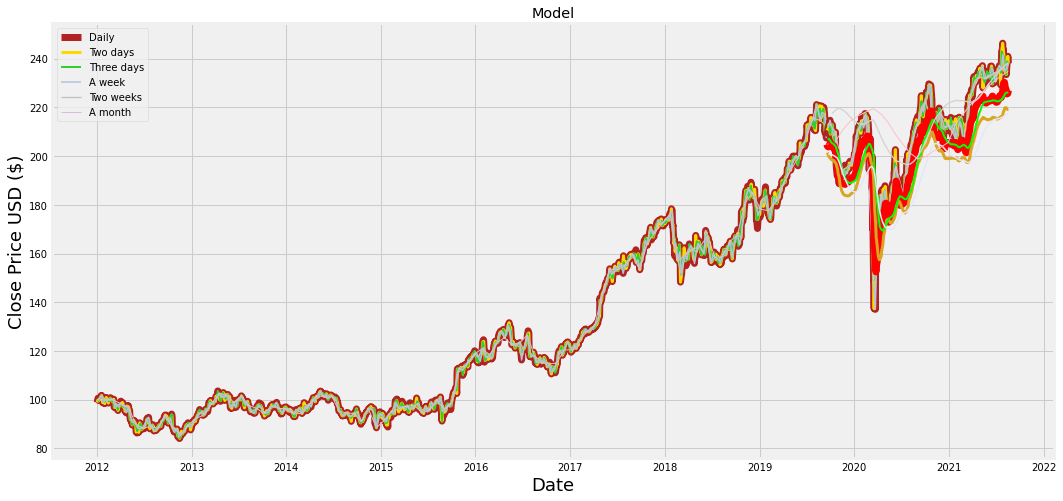

======================= VALIDATION RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) =======================
                 Close  Predictions
Date                               
2019-09-18  210.429993   204.752686
2019-09-19  210.520004   204.295883
2019-09-20  209.389999   204.040405
2019-09-23  211.539993   203.786621
2019-09-24  212.020004   203.790131
...                ...          ...
2021-08-12  236.669998   225.623901
2021-08-13  238.820007   225.506027
2021-08-16  240.970001   225.756790
2021-08-17  240.279999   226.358765
2021-08-18  238.080002   226.964890

[484 rows x 2 columns]
                 Close  Predictions
Date                               
2019-09-19  210.520004   201.402756
2019-09-23  211.539993   200.576218
2019-09-25  212.630005   199.916428
2019-09-27  213.160004   199.478302
2019-10-01  209.020004   199.238434
...                ...          ...
2021-08-06  236.259995   219.887238
2021-08-10  233.449997   219.822357
2021-08-12  236.669998   219.42

In [ ]:
# Create a new dataframe with only the 'Close' column
daily_data = daily_raw_df.filter(['Close'])
twodays_data = twodays_raw_df.filter(['Close'])
threedays_data = threedays_raw_df.filter(['Close'])
week_data = week_raw_df.filter(['Close'])
twoweeks_data = twoweeks_raw_df.filter(['Close'])
month_data = month_raw_df.filter(['Close'])
# Convert the dataframe to a numpy array
daily_dataset = daily_data.values
twodays_dataset = twodays_data.values
threedays_dataset = threedays_data.values
week_dataset = week_data.values
twoweeks_dataset = twoweeks_data.values
month_dataset = month_data.values
# Get the number of rows to train the model on
training_data1_len = math.ceil(len(daily_dataset) * .8)
training_data2_len = math.ceil(len(twodays_dataset) * .8)
training_data3_len = math.ceil(len(threedays_dataset) * .8)
training_data7_len = math.ceil(len(week_dataset) * .8)
training_data14_len = math.ceil(len(twoweeks_dataset) * .8)
training_data28_len = math.ceil(len(month_dataset) * .8)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data1 = scaler.fit_transform(daily_dataset)
scaled_data2 = scaler.fit_transform(twodays_dataset)
scaled_data3 = scaler.fit_transform(threedays_dataset)
scaled_data7 = scaler.fit_transform(week_dataset)
scaled_data14 = scaler.fit_transform(twoweeks_dataset)
scaled_data28 = scaler.fit_transform(month_dataset)

# Create the training data set
# Create the scaled training data set
train_data1 = scaled_data1[0:training_data1_len, :]
train_data2 = scaled_data2[0:training_data2_len, :]
train_data3 = scaled_data3[0:training_data3_len, :]
train_data7 = scaled_data7[0:training_data7_len, :]
train_data14 = scaled_data14[0:training_data14_len, :]
train_data28 = scaled_data28[0:training_data28_len, :]

# Split the data into x_train and y_train data sets
x1_train = [] # 'x' will be the independent training variables or training features
x2_train = []
x3_train = []
x7_train = []
x14_train = []
x28_train = []
y1_train = [] # 'y' will be the dependent variables or target variables
y2_train = []
y3_train = []
y7_train = []
y14_train = []
y28_train = []

# 참고할(훈련시킬) 데이터 길이 ( 2000개 데이터일 때 60개로 잡은 기준으로 해서 비율 0.03으로 함- reference1기준)
# 데이터 사이즈가 너무 작을 수 있으므로 살짝씩 비율을 높여봄 -> 그냥 그대로 하는게 나은거 같기도 하고
reference1 = math.ceil(0.03*len(train_data1))
reference2 = math.ceil(0.05*len(train_data2))
reference3 = math.ceil(0.07*len(train_data3))
reference7 = math.ceil(0.08*len(train_data7))
reference14 = math.ceil(0.09*len(train_data14))
reference28 = math.ceil(0.1*len(train_data28))

# 1
print("="*23 + " x1_train & y1_train " + "="*23)
for i in range(reference1, len(train_data1)):
    x1_train.append(train_data1[i-reference1:i,0])
    y1_train.append(train_data1[i,0])
    if i<= reference1:
        print(x1_train)
        print(y1_train)
        print() # 이거 뭘 프린트 한거냐 > 그냥 new line 빈거
# 2
print("="*23 + " x2_train & y2_train " + "="*23)
for i in range(reference2, len(train_data2)):
    x2_train.append(train_data2[i-reference2:i,0])
    y2_train.append(train_data2[i,0])
    if i<= reference2:
        print(x2_train)
        print(y2_train)
        print() # 이거 뭘 프린트 한거냐 > 그냥 new line 빈거
# 3
print("="*23 + " x3_train & y3_train " + "="*23)
for i in range(reference3, len(train_data3)):
    x3_train.append(train_data3[i-reference3:i,0])
    y3_train.append(train_data3[i,0])
    if i<= reference3:
        print(x3_train)
        print(y3_train)
        print() # 이거 뭘 프린트 한거냐 > 그냥 new line 빈거
# 7
print("="*23 + " x7_train & y7_train " + "="*23)
for i in range(reference7, len(train_data7)):
    x7_train.append(train_data7[i-reference7:i,0])
    y7_train.append(train_data7[i,0])
    if i<= reference7:
        print(x7_train)
        print(y7_train)
        print() # 이거 뭘 프린트 한거냐 > 그냥 new line 빈거
# 14
print("="*23 + " x14_train & y14_train " + "="*23)
for i in range(reference14, len(train_data14)):
    x14_train.append(train_data14[i-reference14:i,0])
    y14_train.append(train_data14[i,0])
    if i<= reference14:
        print(x14_train)
        print(y14_train)
        print() # 이거 뭘 프린트 한거냐 > 그냥 new line 빈거
# 28
print("="*23 + " x28_train & y28_train " + "="*23)
for i in range(reference28, len(train_data28)):
    x28_train.append(train_data28[i-reference28:i,0])
    y28_train.append(train_data28[i,0])
    if i<= reference28:
        print(x28_train)
        print(y28_train)
        print() # 이거 뭘 프린트 한거냐 > 그냥 new line 빈거


# Convert the x_train and y_train to numpy arrays for the LSTM model
x1_train, y1_train = np.array(x1_train), np.array(y1_train)
x2_train, y2_train = np.array(x2_train), np.array(y2_train)
x3_train, y3_train = np.array(x3_train), np.array(y3_train)
x7_train, y7_train = np.array(x7_train), np.array(y7_train)
x14_train, y14_train = np.array(x14_train), np.array(y14_train)
x28_train, y28_train = np.array(x28_train), np.array(y28_train)

# Reshape the data ( because LSTM model wants 3-dimensional data)
# print(x_train.shape) example-> result is (1543, 60), 2-dimension
x1_train = np.reshape(x1_train,(x1_train.shape[0],x1_train.shape[1],1))
x2_train = np.reshape(x2_train,(x2_train.shape[0],x2_train.shape[1],1))
x3_train = np.reshape(x3_train,(x3_train.shape[0],x3_train.shape[1],1))
x7_train = np.reshape(x7_train,(x7_train.shape[0],x7_train.shape[1],1))
x14_train = np.reshape(x14_train,(x14_train.shape[0],x14_train.shape[1],1))
x28_train = np.reshape(x28_train,(x28_train.shape[0],x28_train.shape[1],1))
# After reshaping, print(x_train.shape) example -> result is (1543, 60, 1), 3-dimension
# And to make the code robust, it is better to write the code instead of the number
# for example, x_train.shape[0] instead of 1543

# Build the LSTM model (Architecture)
model1, model2, model3, model7, model14, model28 = \
    Sequential(), Sequential(), Sequential(), Sequential(), Sequential(), Sequential()
# 50 neurons, return_sequence is True because we are going to use another LSTM layer
# and because this is the very first layer we need to give it a input shape,
# (time step,1) -> (x_train.shape[1],1)
# 일단 데이터 비율에 맞게 neuron 수 조정해봄 -> 근데 동영상에서는 dense하게 짜여진 구조가 이렇다고 말하긴 함
# 그래서 실험적으로 해보는게 좋을 듯 (한 목표 날짜 두고 값 비교 형식으로)
# -> 그냥 모두 같은 구조로 먼저 해보자
model1.add(LSTM(50, return_sequences=True, input_shape= (x1_train.shape[1],1)))
model2.add(LSTM(50, return_sequences=True, input_shape= (x2_train.shape[1],1)))
model3.add(LSTM(50, return_sequences=True, input_shape= (x3_train.shape[1],1)))
model7.add(LSTM(50, return_sequences=True, input_shape= (x7_train.shape[1],1)))
model14.add(LSTM(50, return_sequences=True, input_shape= (x14_train.shape[1],1)))
model28.add(LSTM(50, return_sequences=True, input_shape= (x28_train.shape[1],1)))
# Add second LSTM
model1.add(LSTM(50, return_sequences = False))
model2.add(LSTM(50, return_sequences = False))
model3.add(LSTM(50, return_sequences = False))
model7.add(LSTM(50, return_sequences = False))
model14.add(LSTM(50, return_sequences = False))
model28.add(LSTM(50, return_sequences = False))
# Add 25neurons Dense layer, and this is your regularly densely connected
# neural network layer with 25 neurons
model1.add(Dense(25))
model2.add(Dense(25))
model3.add(Dense(25))
model7.add(Dense(25))
model14.add(Dense(25))
model28.add(Dense(25))

model1.add(Dense(1))
model2.add(Dense(1))
model3.add(Dense(1))
model7.add(Dense(1))
model14.add(Dense(1))
model28.add(Dense(1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')
model2.compile(optimizer='adam', loss='mean_squared_error')
model3.compile(optimizer='adam', loss='mean_squared_error')
model7.compile(optimizer='adam', loss='mean_squared_error')
model14.compile(optimizer='adam', loss='mean_squared_error')
model28.compile(optimizer='adam', loss='mean_squared_error')
# Optimization Algorithm

# Train the model
model1.fit(x1_train, y1_train, batch_size=1, epochs=1)
model2.fit(x2_train, y2_train, batch_size=1, epochs=1)
model3.fit(x3_train, y3_train, batch_size=1, epochs=1)
model7.fit(x7_train, y7_train, batch_size=1, epochs=1)
model14.fit(x14_train, y14_train, batch_size=1, epochs=1)
model28.fit(x28_train, y28_train, batch_size=1, epochs=1)
# batch_size is the total number of training examples present in a single batch(묶음)
# epoch is the number of iterations when an entire dataset is passed forward and backward through a neural network
# So, if your RAM can handle, increasing epochs will increase the accuracy
# Create the testing data set
# Create a new array containing scaled values from index 'all-(training_data_len-reference)' to 'all'
test_data1 = scaled_data1[training_data1_len - reference1:, :]
test_data2 = scaled_data2[training_data2_len - reference2:, :]
test_data3 = scaled_data3[training_data3_len - reference3:, :]
test_data7 = scaled_data7[training_data7_len - reference7:, :]
test_data14 = scaled_data14[training_data14_len - reference14:, :]
test_data28 = scaled_data28[training_data28_len - reference28:, :]

# Create the data sets x_test and y_test
x1_test, x2_test, x3_test, x7_test, x14_test, x28_test = [], [], [], [], [], []
y1_test = daily_dataset[training_data1_len:, :] # values that we want our model to predict
y2_test = twodays_dataset[training_data2_len:, :]
y3_test = threedays_dataset[training_data3_len:, :]
y7_test = week_dataset[training_data7_len:, :]
y14_test = twoweeks_dataset[training_data14_len:, :]
y28_test = month_dataset[training_data28_len:, :]
for i in range(reference1, len(test_data1)):
    x1_test.append(test_data1[i - reference1:i, 0])
for i in range(reference2, len(test_data2)):
    x2_test.append(test_data2[i - reference2:i, 0])
for i in range(reference3, len(test_data3)):
    x3_test.append(test_data3[i - reference3:i, 0])
for i in range(reference7, len(test_data7)):
    x7_test.append(test_data7[i - reference7:i, 0])
for i in range(reference14, len(test_data14)):
    x14_test.append(test_data14[i - reference14:i, 0])
for i in range(reference28, len(test_data28)):
    x28_test.append(test_data28[i - reference28:i, 0])

# Convert the data to a numpy array
x1_test = np.array(x1_test)
x2_test = np.array(x2_test)
x3_test = np.array(x3_test)
x7_test = np.array(x7_test)
x14_test = np.array(x14_test)
x28_test = np.array(x28_test)
# Reshape the data (2D ->3D)
x1_test = np.reshape(x1_test, (x1_test.shape[0], x1_test.shape[1], 1))
x2_test = np.reshape(x2_test, (x2_test.shape[0], x2_test.shape[1], 1))
x3_test = np.reshape(x3_test, (x3_test.shape[0], x3_test.shape[1], 1))
x7_test = np.reshape(x7_test, (x7_test.shape[0], x7_test.shape[1], 1))
x14_test = np.reshape(x14_test, (x14_test.shape[0], x14_test.shape[1], 1))
x28_test = np.reshape(x28_test, (x28_test.shape[0], x28_test.shape[1], 1))

# Get the models predicted price values
predictions1 = model1.predict(x1_test)
predictions2 = model2.predict(x2_test)
predictions3 = model3.predict(x3_test)
predictions7 = model7.predict(x7_test)
predictions14 = model14.predict(x14_test)
predictions28 = model28.predict(x28_test)
# unscaling the values
predictions1 = scaler.inverse_transform(predictions1)
predictions2 = scaler.inverse_transform(predictions2)
predictions3 = scaler.inverse_transform(predictions3)
predictions7 = scaler.inverse_transform(predictions7)
predictions14 = scaler.inverse_transform(predictions14)
predictions28 = scaler.inverse_transform(predictions28)

# Get the root mean squared error (RMSE)
# RMSE is a good measure of how accurate the model predicts the response
# and it's the standard deviation of the residuals
# and the lower values of RMSE indicate a better fit
rmse1 = np.sqrt(np.mean(predictions1 - y1_test)**2)
rmse2 = np.sqrt(np.mean(predictions2 - y2_test)**2)
rmse3 = np.sqrt(np.mean(predictions3 - y3_test)**2)
rmse7 = np.sqrt(np.mean(predictions7 - y7_test)**2)
rmse14 = np.sqrt(np.mean(predictions14 - y14_test)**2)
rmse28 = np.sqrt(np.mean(predictions28 - y28_test)**2)
# 평균 제곱근 오차는 추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 흔히 사용하는 측도이다.
# 정밀도(precision)를 표현하는데 적합하다. 테스트데이터값들과 예측값들의 표준 오차라고 생각하면 될 듯
# 단위(달러, 원, 등등)에 따라 괜찮다고 생각되는 표준오차범위 내에 있으면 될 듯 (영상에서는 5달러 꽤 decent하다고 함)
print("="*23 + " RMSE RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) " + "="*23)
print(rmse1, rmse2, rmse3, rmse7, rmse14, rmse28)
# -> 결과 확인해보니 (매번 다름)
# 4.6500044172736485 7.34976423547623 16.517728185957406 15.511049230047997 15.793584458371425 4.942750682001528
# 몇몇은 오차가 조금 큰거 같다,, 오버피팅인가 아니면 그냥 weight 조절해주면서 하면 되는건가, 일단 진행

# Plot the data
train1 = daily_data[:training_data1_len]
train2 = twodays_data[:training_data2_len]
train3 = threedays_data[:training_data3_len]
train7 = week_data[:training_data7_len]
train14 = twoweeks_data[:training_data14_len]
train28 = month_data[:training_data28_len]

valid1 = daily_data[training_data1_len:]
valid2 = twodays_data[training_data2_len:]
valid3 = threedays_data[training_data3_len:]
valid7 = week_data[training_data7_len:]
valid14 = twoweeks_data[training_data14_len:]
valid28 = month_data[training_data28_len:]
# 복사본을 분리해서 생성해야 경고 안뜸
valid1, valid2, valid3, valid7, valid14, valid28 = \
    valid1.copy(), valid2.copy(), valid3.copy(), valid7.copy(), valid14.copy(), valid28.copy()
valid1['Predictions'] = predictions1
valid2['Predictions'] = predictions2
valid3['Predictions'] = predictions3
valid7['Predictions'] = predictions7
valid14['Predictions'] = predictions14
valid28['Predictions'] = predictions28

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)

plt.plot(train1['Close'], linewidth=7, color='firebrick')
plt.plot(train2['Close'], linewidth=3, color='gold')
plt.plot(train3['Close'], linewidth=2, color='limegreen')
plt.plot(train7['Close'], linewidth=1.5, color='lightsteelblue')
plt.plot(train14['Close'], linewidth=1.3, color='silver')
plt.plot(train28['Close'], linewidth=1, color='thistle')
# two square bracket needed when you want to plot more than one column, ex. valid1[['Close', 'Predictions']]
plt.plot(valid1['Close'], linewidth=7, color='firebrick')
plt.plot(valid2['Close'], linewidth=3, color='gold')
plt.plot(valid3['Close'], linewidth=2, color='limegreen')
plt.plot(valid7['Close'], linewidth=1.5, color='lightsteelblue')
plt.plot(valid14['Close'], linewidth=1.3, color='silver')
plt.plot(valid28['Close'], linewidth=1, color='thistle')
# 색깔을 실제 데이터 라인들의 색깔보다 살짝씩 연한 색으로 함 (비슷한 계열의 색)
plt.plot(valid1['Predictions'], linewidth=7, color='red')
plt.plot(valid2['Predictions'], linewidth=3, color='goldenrod')
plt.plot(valid3['Predictions'], linewidth=2, color='lime')
plt.plot(valid7['Predictions'], linewidth=1.5, color='lavender')
plt.plot(valid14['Predictions'], linewidth=1.3, color='lightgrey')
plt.plot(valid28['Predictions'], linewidth=1, color='pink')

plt.legend(['Daily', 'Two days', 'Three days', 'A week', 'Two weeks', 'A month'], loc='upper left')
plt.show()

print("="*23 + " VALIDATION RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) " + "="*23)
print(valid1)
print(valid2)
print(valid3)
print(valid7)
print(valid14)
print(valid28)
# 여기까지 한 결과 -> 발견한 점들
# (RMSE결과값도 그렇고 그래프 값도 그렇고) 주간데이터, 3일데이터, 2주데이터는 오류가 좀 많이 커 보인다.
# 추가적으로 epoch수 혹은 neuron수를 조절해봐야하는 작업이 필요할 것 같다.
# 그리고 월간데이의 경우 오차가 생각보다 적은 것으로 확인되었는데, lagging으로 인해 우연히 값이 비슷할 것으로도 예상된다. (따라서 신빙성 의심)
# 전체적으로 그래프가 오른쪽으로 lagging되는 현상이 보인다( https://www.youtube.com/watch?v=dB8cpsnZ5FA&list=WL&index=4&t=950s)
# 이 문제는 해결하기에는 힘들거 같고, 유투브 통해서 lagging되는 이유 찾아서 설명해주면 될듯

# 그런데 결국에는 모든 예측값들을 사용하고 싶다면, weight로 조절을 해줘야할 것 같다.
# 그래서 우리가 모여서 할거는 neuron, dense, epoch, batch size, weight 여러번 실험적으로 바꿔가면서 최적의 모델 만들기
# 이미 나와 있는 최근의 주가 데이터들로 정확도를 확인할 것임.
########################################################################################

# Get the quote
Quote = web.DataReader('MCD', data_source='yahoo', start='2012-01-01', end='2021-08-18')
# Create a new dataframe
new_df1 = Quote.filter(['Close'])
new_df2 = new_df1[len(new_df1)::-2]
new_df2 = new_df2[::-1]
new_df3 = new_df1[len(new_df1)::-3]
new_df3 = new_df3[::-1]
new_df7 = new_df1[len(new_df1)::-5]
new_df7 = new_df7[::-1]
new_df14 = new_df1[len(new_df1)::-10]
new_df14 = new_df14[::-1]
new_df28 = new_df1[len(new_df1)::-20]
new_df28 = new_df28[::-1]
# Get the last days'(references) closing price values and convert the dataframe to an array
# 이제는 가져온 데이터의 최근 reference길이 만큼의 Sequence만 가져온 후에 미래(다음에 나올 데이터)를 예측한다.
new_reference1 = new_df1[-reference1:].values
new_reference2 = new_df2[-reference2:].values
new_reference3 = new_df3[-reference3:].values
new_reference7 = new_df7[-reference7:].values
new_reference14 = new_df14[-reference14:].values
new_reference28 = new_df28[-reference28:].values
# Scale the data to be values between 0 and 1
# I am not using fit transform because I want it to transform the data using
# those same min and max values that we used when we first transform the data
"""
추가설명
(https://www.inflearn.com/questions/19038)
1. 사이킷런의 지도학습의 주요 메소드인 fit()과 predict()와 
비슷한 API로 사용자들의 보다 쉬운 이해를 돕기 위해서.

2. 학습데이터 세트에서 변환을 위한 기반 설정
(예를 들어 학습 데이터 세트의 최대값/최소값등)을 먼저 fit()을 통해서 설정한 뒤에 
이를 기반으로 학습 데이터의 transform()을 수행하되 학습 데이터에서 설정된 변환을 
위한 기반 설정을 그대로 테스트 데이터에도 적용하기 위해서입니다.
즉 학습 데이터 세트로 fit() 된 Scaler를 이용하여 테스트 데이터를 변환할 경우에는  
테스트 데이터에서 다시 fit()하지 않고 반드시 그대로 이 Scaler를 이용하여 
transform()을 수행해야 합니다.
가령 아래와 같이 Iris 학습 데이터 세트로 MinMaxScaler() 를 생성한 뒤 fit()하고 
transform() 한 뒤 Classifier로 학습 했다면 예측 시 먼저 테스트 데이터 세트를  
반드시 학습 데이터로 Scaling된 MinMaxScaler를 이용하여 fit()한 뒤 transform() 
해야 됩니다. 즉 학습할 때와 동일한 기반 설정으로 동일하게 테스트 데이터를 변환해야 
하는 것입니다.  학습 데이터에서 Scale된 데이터를 기반으로 Classifier가 학습이 되었기 
때문에 이렇게 학습된 Classifier가 예측을 할 때에도 학습 데이터의 Scale 기준으로 
테스트 데이터를 변환 한 뒤 predict해야 합니다.
"""
new_reference1_scaled = scaler.transform(new_reference1)
new_reference2_scaled = scaler.transform(new_reference2)
new_reference3_scaled = scaler.transform(new_reference3)
new_reference7_scaled = scaler.transform(new_reference7)
new_reference14_scaled = scaler.transform(new_reference14)
new_reference28_scaled = scaler.transform(new_reference28)
# Create an empty list
X1_test, X2_test, X3_test, X7_test, X14_test, X28_test = [], [], [], [], [], []
# Append the past days (references)
X1_test.append(new_reference1_scaled)
X2_test.append(new_reference2_scaled)
X3_test.append(new_reference3_scaled)
X7_test.append(new_reference7_scaled)
X14_test.append(new_reference14_scaled)
X28_test.append(new_reference28_scaled)
# Convert the X_test data set to a numpy array
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
X3_test = np.array(X3_test)
X7_test = np.array(X7_test)
X14_test = np.array(X14_test)
X28_test = np.array(X28_test)
# Reshape the data
X1_test = np.reshape(X1_test, (X1_test.shape[0], X1_test.shape[1], 1))
X2_test = np.reshape(X2_test, (X2_test.shape[0], X2_test.shape[1], 1))
X3_test = np.reshape(X3_test, (X3_test.shape[0], X3_test.shape[1], 1))
X7_test = np.reshape(X7_test, (X7_test.shape[0], X7_test.shape[1], 1))
X14_test = np.reshape(X14_test, (X14_test.shape[0], X14_test.shape[1], 1))
X28_test = np.reshape(X28_test, (X28_test.shape[0], X28_test.shape[1], 1))

# Get the predicted scaled price
pred_price1 = model1.predict(X1_test)
pred_price2 = model2.predict(X2_test)
pred_price3 = model3.predict(X3_test)
pred_price7 = model7.predict(X7_test)
pred_price14 = model14.predict(X14_test)
pred_price28 = model28.predict(X28_test)
# Undo the scaling
pred_price1 = scaler.inverse_transform(pred_price1)
pred_price2 = scaler.inverse_transform(pred_price2)
pred_price3 = scaler.inverse_transform(pred_price3)
pred_price7 = scaler.inverse_transform(pred_price7)
pred_price14 = scaler.inverse_transform(pred_price14)
pred_price28 = scaler.inverse_transform(pred_price28)

print("="*23 + " PREDICTED PRICES RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) " + "="*23)
print(pred_price1, pred_price2, pred_price3, pred_price7, pred_price14, pred_price28)
#-> the result is a predicted price of the next day of the 'end day'

# 나온 값들로 weight 주는 반복 작업 진행하면 돼 ( 이 뒤로는 ) , 이 작업 하기전에 뉴런 수랑 에폭 수 등등 결정하고 넘어가야함


# Weight 지정
print("="*23 + " 2021.08.19 PRICE RESULT " + "="*23)
print(0.6*pred_price1 + \
      0.2*pred_price2 + \
      0.1*pred_price3 + \
      0.06*pred_price7 + \
      0.03*pred_price14 + \
      0.01*pred_price28)

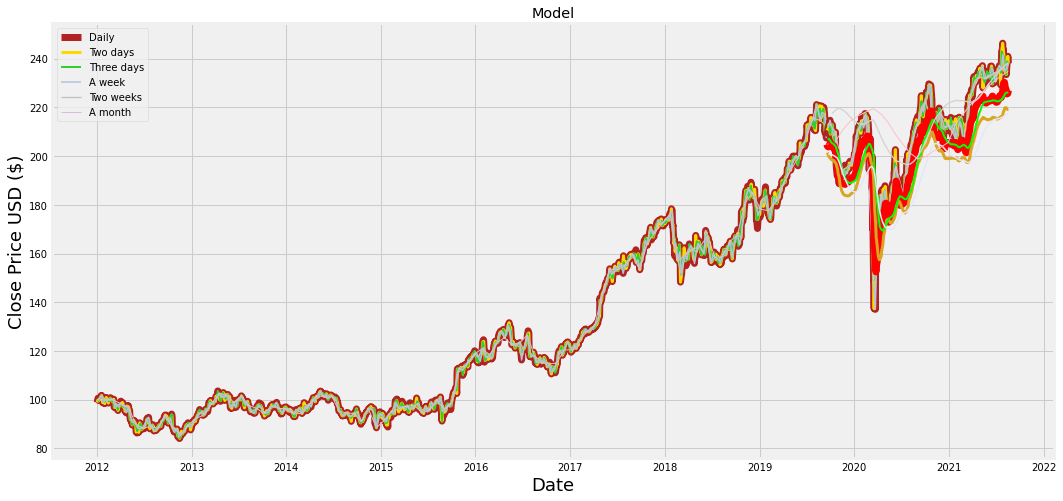

In [ ]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)

plt.plot(train1['Close'], linewidth=7, color='firebrick')
plt.plot(train2['Close'], linewidth=3, color='gold')
plt.plot(train3['Close'], linewidth=2, color='limegreen')
plt.plot(train7['Close'], linewidth=1.5, color='lightsteelblue')
plt.plot(train14['Close'], linewidth=1.3, color='silver')
plt.plot(train28['Close'], linewidth=1, color='thistle')
# two square bracket needed when you want to plot more than one column, ex. valid1[['Close', 'Predictions']]
plt.plot(valid1['Close'], linewidth=7, color='firebrick')
plt.plot(valid2['Close'], linewidth=3, color='gold')
plt.plot(valid3['Close'], linewidth=2, color='limegreen')
plt.plot(valid7['Close'], linewidth=1.5, color='lightsteelblue')
plt.plot(valid14['Close'], linewidth=1.3, color='silver')
plt.plot(valid28['Close'], linewidth=1, color='thistle')
# 색깔을 실제 데이터 라인들의 색깔보다 살짝씩 연한 색으로 함 (비슷한 계열의 색)
plt.plot(valid1['Predictions'], linewidth=7, color='red')
plt.plot(valid2['Predictions'], linewidth=3, color='goldenrod')
plt.plot(valid3['Predictions'], linewidth=2, color='lime')
plt.plot(valid7['Predictions'], linewidth=1.5, color='lavender')
plt.plot(valid14['Predictions'], linewidth=1.3, color='lightgrey')
plt.plot(valid28['Predictions'], linewidth=1, color='pink')

plt.legend(['Daily', 'Two days', 'Three days', 'A week', 'Two weeks', 'A month'], loc='upper left')
plt.show()

In [ ]:
print("="*23 + " RMSE RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) " + "="*23)
print(rmse1, rmse2, rmse3, rmse7, rmse14, rmse28)
print("="*23 + " PREDICTED PRICES RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) " + "="*23)
print(pred_price1, pred_price2, pred_price3, pred_price7, pred_price14, pred_price28)
print("="*23 + " 2021.08.19 PRICE RESULT " + "="*23)
print(0.6*pred_price1 + \
      0.2*pred_price2 + \
      0.1*pred_price3 + \
      0.06*pred_price7 + \
      0.03*pred_price14 + \
      0.01*pred_price28)

======================= RMSE RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) =======================
7.1656690234980305 13.43608805758894 7.970757146799786 14.152908325195312 6.544777552286784 5.454089482625325
======================= PREDICTED PRICES RESULTS (Daily TwoDays ThreeDays Weekly TwoWeeks Monthly) =======================
[[234.1109]] [[225.30945]] [[230.39035]] [[220.43523]] [[239.74425]] [[238.26064]]
======================= 2021.08.19 PRICE RESULT =======================
[[231.36852]]
